Notes: 
- mean: 5.37 (high severity)
- median: 5.0
- range: 0 - 19

- 문제: 나이 기준이 정확하지 않음. Concepts에서 계산한 나이 기준으로 age_score 불일치. (내가 따로 나이 계산했을 때도 동일한 문제 발생.)
    - 해결법: CCI 칼럼을 그대로 쓰기 보다는, 원자료에서 age_score를 concepts age로 보정해준 다음, 다시 CCI 계산해야함. 
    - CCI 계산법 (Charlson, 1987 기준): mimic 소스 코드 참조 [mimic_concepts.charlson.sql](https://github.com/MIT-LCP/mimic-iv/blob/282a836ab43a81f808992147e94fd4e7c131db1e/concepts/comorbidity/charlson.sql)


In [2]:
import numpy as np
import pandas as pd
from dfply import *
import matplotlib.pyplot as plt
import missingno as msno
from datetime import timedelta
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')
# 데이터 정제 시 필요한 모듈들
import src.subjectlist_alignment.pairing as pairing   # 삽관 발관 페어링 관련 모듈
from src.subjectlist_alignment import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src.subjectlist_alignment import imputation as imp   # 결측치 대체 관련 모듈
from src.subjectlist_alignment import subject_classification as cls
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')
import src.utils.utils as utils   # 기타 유틸리티 모듈
import src.data_extraction.access_database as db   # DB 연결 관련 모듈

In [3]:
# 변수를 붙일 subjectlist 데이터 가져오기

data_dir = '../outputs/subjectlist1.csv'
subjectlist1 = pd.read_csv(data_dir, index_col=0)

# datetime 변환
time_cols = ['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime', 'reintubation_eventtime']
subjectlist1 = utils.to_datetime(subjectlist1, time_cols)
print(subjectlist1.shape)
subjectlist1.head()

Converted admittime to datetime.
Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
Converted reintubation_eventtime to datetime.
(9003, 29)


,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,intext_duration,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,26184834,37510196,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,...,2230.0,NaT,NaN,False,True,10775.0,10775.0,0.0,11,nonfailure
1,10003400,23559586,38383343,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,...,5419.0,NaT,NaN,False,True,17365.0,17365.0,0.0,11,nonfailure
2,10004401,27939719,31202136,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,31202136.0,2144-04-13 15:00:00,...,3477.0,NaT,NaN,False,True,NaN,151.0,NaN,121,nonfailure
3,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,...,3930.0,2144-01-30 13:00:00,30.0,False,False,NaN,10035.0,NaN,211,failure
4,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,...,10005.0,NaT,NaN,False,True,NaN,0.0,NaN,2221,nonfailure


### DB 추출

In [8]:
# DB 연결 테이블 후 가져오기

database_config = {'database': 'mimic4',
 'user': 'postgres',
 'password': '1234',
 'host': 'localhost',
 'port': 5432}

tables_query = {
    'age': "select * from mimiciv_derived.age;",
    'charlson': "select * from mimiciv_derived.charlson;",
    'apsiii': "select * from mimiciv_derived.apsiii;",
    'oasis': "select * from mimiciv_derived.oasis;",
    'sofa': "select * from mimiciv_derived.sofa;",
    'sepsis3': "select * from mimiciv_derived.sepsis3;",
    'sapsii': "select * from mimiciv_derived.sapsii;"
                }


db.print_config_info(database_config, tables_query)
conn = db.connect_to_database(database_config)
dataframes = db.retrieve_data(conn, tables_query)
db.disconnect_database(conn)

# pg_tables = dataframes['pg_tables']
# patients = dataframes['patients']
# d_items = dataframes['d_items']

age = dataframes['age']
charlson = dataframes['charlson']
apsiii = dataframes['apsiii']
oasis = dataframes['oasis']
sofa = dataframes['sofa']   # 오래 걸리는 듯
sepsis3 = dataframes['sepsis3']
sapsii = dataframes['sapsii']


INFO:root:CONNECTING TO DATABASE...


--------- Database Configuration ---------
Database Name: mimic4
User: postgres
Password: ****
Host: localhost
Port: 5432

--------- SQL Queries for Required Tables ---------
age: select * from mimiciv_derived.age;
charlson: select * from mimiciv_derived.charlson;
apsiii: select * from mimiciv_derived.apsiii;
oasis: select * from mimiciv_derived.oasis;
sofa: select * from mimiciv_derived.sofa;
sepsis3: select * from mimiciv_derived.sepsis3;
sapsii: select * from mimiciv_derived.sapsii;



INFO:root:Retrieved age: (431231, 6)
INFO:root:Retrieved charlson: (431231, 21)
INFO:root:Retrieved apsiii: (73181, 21)
INFO:root:Retrieved oasis: (73181, 25)
INFO:root:Retrieved sofa: (6046508, 29)
INFO:root:Retrieved sepsis3: (32971, 14)
INFO:root:Retrieved sapsii: (73181, 22)
INFO:root:DATABASE CONNCETION CLOSED.


In [10]:
# age.to_csv('../outputs/age.csv', index=False, encoding='utf-8-sig')
# charlson.to_csv('../outputs/charlson.csv', index=False, encoding='utf-8-sig')
# apsiii.to_csv('../outputs/apsiii.csv', index=False, encoding='utf-8-sig')
# oasis.to_csv('../outputs/oasis.csv', index=False, encoding='utf-8-sig')
# sapsii.to_csv('../outputs/sapsii.csv', index=False, encoding='utf-8-sig')
# sofa.to_csv('../outputs/sofa.csv', index=False, encoding='utf-8-sig')
# sepsis3.to_csv('../outputs/sepsis3.csv', index=False, encoding='utf-8-sig')

### subjectlist 단순화 + age 와 결합

In [7]:
charlson = pd.read_csv('../outputs/charlson.csv')
age = pd.read_csv('../outputs/age.csv')

In [28]:
charlson

,subject_id,hadm_id,age_score,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,...,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,charlson_comorbidity_index,calculated_cci,is_cci_correct
0,18910522,20000041,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,3,True
1,14546051,20000069,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
2,19618591,20000200,2,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,5,5,True
3,16179342,20000298,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,5,5,True
4,15325429,20000400,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431226,14351952,29999277,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,True
431227,17128602,29999326,2,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,8,8,True
431228,10053207,29999444,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,True
431229,10698563,29999501,3,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,5,5,True


In [9]:
cols = ['subject_id', 'hadm_id', 'stay_id', 'admittime', 'dischtime', 'deathtime', 'class']
# unique_hadms = list(subjectlist1.hadm_id.unique())
trimmed_table = subjectlist1[cols]

sl = pd.merge(trimmed_table, age[['subject_id', 'hadm_id', 'age']], on=['subject_id', 'hadm_id'], how='left')

sl['age'] = pd.to_numeric(sl['age'], errors='coerce')
sl['age'] = sl['age'].round(2)

sl

,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,nonfailure,75.59
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-13 17:31:00,NaT,nonfailure,85.27
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,failure,85.06
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,nonfailure,85.06
...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30
8999,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30
9000,19999068,21606769,30143796,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,nonfailure,63.64
9001,19999442,26785317,32336619,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,nonfailure,43.88


### Charlson Comorbidity Score (charlson)
- 문제: age 테이블에서 가져온 환자 나이와 charlson 테이블의 age_score 불일치. 

In [10]:
charlson

,subject_id,hadm_id,age_score,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,...,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,charlson_comorbidity_index
0,18910522,20000041,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3
1,14546051,20000069,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19618591,20000200,2,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,5
3,16179342,20000298,3,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
4,15325429,20000400,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431226,14351952,29999277,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
431227,17128602,29999326,2,0,1,0,0,0,1,0,...,1,1,0,0,0,1,0,0,0,8
431228,10053207,29999444,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
431229,10698563,29999501,3,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [11]:
charlson.columns

Index(['subject_id', 'hadm_id', 'age_score', 'myocardial_infarct',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
       'renal_disease', 'malignant_cancer', 'severe_liver_disease',
       'metastatic_solid_tumor', 'aids', 'charlson_comorbidity_index'],
      dtype='object')

In [12]:
unique_cci = charlson['charlson_comorbidity_index'].unique()
pd.Series(unique_cci).sort_values().values


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [30]:
# 중복값?
charlson_duplicates = charlson.duplicated(subset=['hadm_id'], keep=False)
charlson_duplicate_count = charlson_duplicates.sum()
charlson_duplicate_count

0

In [13]:
# 개별 칼럼값을 다 더했을 때 최종 CCI 값과 일치하는지 consistency check.

# Assuming 'charlson' is your DataFrame
# Apply specific weights and conditions as per the source code
charlson['calculated_cci'] = (
    charlson['age_score'] +
    charlson['myocardial_infarct'] +
    charlson['congestive_heart_failure'] +
    charlson['peripheral_vascular_disease'] +
    charlson['cerebrovascular_disease'] +
    charlson['dementia'] +
    charlson['chronic_pulmonary_disease'] +
    charlson['rheumatic_disease'] +
    charlson['peptic_ulcer_disease'] +
    np.maximum(charlson['mild_liver_disease'], 3 * charlson['severe_liver_disease']) +
    np.maximum(2 * charlson['diabetes_with_cc'], charlson['diabetes_without_cc']) +
    np.maximum(2 * charlson['malignant_cancer'], 6 * charlson['metastatic_solid_tumor']) +
    2 * charlson['paraplegia'] +
    2 * charlson['renal_disease'] +
    6 * charlson['aids']
)

# Check if the calculated CCI matches the 'charlson_comorbidity_index' column
charlson['is_cci_correct'] = charlson['calculated_cci'] == charlson['charlson_comorbidity_index']

# Inspect mismatches
mismatches = charlson[charlson['is_cci_correct'] == False]
print(f"Number of mismatches: {len(mismatches)}")

# Optional: Display mismatches
if len(mismatches) > 0:
    print("Mismatches found:", mismatches[['subject_id', 'hadm_id', 'calculated_cci', 'charlson_comorbidity_index']])
else:
    print("All calculated CCI scores match the provided CCI scores.")


Number of mismatches: 0
All calculated CCI scores match the provided CCI scores.


In [14]:
# sl 테이블과 조인
sl2 = pd.merge(sl, charlson[['subject_id', 'hadm_id', 'age_score', 'charlson_comorbidity_index']], on=['subject_id', 'hadm_id'], how='left')
sl2.rename(columns={'charlson_comorbidity_index':'cci'}, inplace=True)
sl2

,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age,age_score,cci
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02,3,5
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,nonfailure,75.59,3,12
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-13 17:31:00,NaT,nonfailure,85.27,4,5
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,failure,85.06,4,5
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,nonfailure,85.06,4,5
...,...,...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30,2,7
8999,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30,2,7
9000,19999068,21606769,30143796,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,nonfailure,63.64,2,3
9001,19999442,26785317,32336619,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,nonfailure,43.88,0,4


In [15]:
sl2[(sl2.age <= 50) & (sl2.age > 40)].age_score.unique()

array([0])

나이를 직접 계산해보자..

In [16]:
# DB 연결 테이블 후 가져오기

database_config = {'database': 'mimic4',
 'user': 'postgres',
 'password': '1234',
 'host': 'localhost',
 'port': 5432}

tables_query = {
    'patients': 'SELECT * FROM mimiciv_hosp.patients;'
                }


db.print_config_info(database_config, tables_query)
conn = db.connect_to_database(database_config)
dataframes = db.retrieve_data(conn, tables_query)
db.disconnect_database(conn)

# pg_tables = dataframes['pg_tables']
# patients = dataframes['patients']
# d_items = dataframes['d_items']

patients = dataframes['patients']



INFO:root:CONNECTING TO DATABASE...


--------- Database Configuration ---------
Database Name: mimic4
User: postgres
Password: ****
Host: localhost
Port: 5432

--------- SQL Queries for Required Tables ---------
patients: SELECT * FROM mimiciv_hosp.patients;



INFO:root:Retrieved patients: (299712, 6)
INFO:root:DATABASE CONNCETION CLOSED.


In [17]:
sl2 = pd.merge(sl2, patients[['subject_id', 'anchor_year', 'anchor_age']], on=['subject_id'], how='left')
sl2

,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age,age_score,cci,anchor_year,anchor_age
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02,3,5,2122,68
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,nonfailure,75.59,3,12,2134,72
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-13 17:31:00,NaT,nonfailure,85.27,4,5,2141,82
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,failure,85.06,4,5,2141,82
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,nonfailure,85.06,4,5,2141,82
...,...,...,...,...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30,2,7,2126,63
8999,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30,2,7,2126,63
9000,19999068,21606769,30143796,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,nonfailure,63.64,2,3,2161,63
9001,19999442,26785317,32336619,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,nonfailure,43.88,0,4,2146,41


In [18]:
# 나이 계산
sl2 = utils.calculate_adjusted_anchor_age(sl2)
sl2

,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age,age_score,cci,anchor_year,anchor_age,adj_anchor_age
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02,3,5,2122,68,77.02
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,nonfailure,75.59,3,12,2134,72,75.59
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-13 17:31:00,NaT,nonfailure,85.27,4,5,2141,82,85.27
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,failure,85.06,4,5,2141,82,85.06
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,nonfailure,85.06,4,5,2141,82,85.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30,2,7,2126,63,63.30
8999,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30,2,7,2126,63,63.30
9000,19999068,21606769,30143796,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,nonfailure,63.64,2,3,2161,63,63.64
9001,19999442,26785317,32336619,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,nonfailure,43.88,0,4,2146,41,43.88


In [19]:
sl2[sl2.age != sl2.adj_anchor_age]

,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age,age_score,cci,anchor_year,anchor_age,adj_anchor_age
10,10017679,29739025,33035972,2132-06-04 20:30:00,2132-06-13 16:45:00,NaT,nonfailure,71.43,3,3,2132,71,71.42
24,10032381,20176432,34622731,2115-06-27 13:38:00,2115-08-17 13:30:00,NaT,nonfailure,64.49,2,3,2115,64,64.48
25,10032381,20176432,34622731,2115-06-27 13:38:00,2115-08-17 13:30:00,NaT,nonfailure,64.49,2,3,2115,64,64.48
28,10035168,26166196,36460006,2146-12-22 17:46:00,2147-01-07 08:30:00,2147-01-07 08:30:00,death,58.98,1,3,2144,56,58.97
37,10051043,23260768,36748093,2192-10-06 19:14:00,2192-10-21 15:15:00,NaT,nonfailure,60.77,2,2,2192,60,60.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8947,19933770,27972684,38243228,2158-09-08 21:23:00,2158-10-02 06:05:00,2158-10-02 06:05:00,nonfailure,60.69,2,10,2157,59,60.68
8962,19960105,27292691,31512322,2147-08-06 18:06:00,2147-08-23 14:16:00,NaT,NaN,66.60,2,4,2146,65,66.59
8963,19960105,27292691,31512322,2147-08-06 18:06:00,2147-08-23 14:16:00,NaT,nonfailure,66.60,2,4,2146,65,66.59
8980,19974380,27355109,35371457,2182-06-30 22:33:00,2182-07-12 18:10:00,NaT,nonfailure,80.50,4,7,2180,78,80.49


In [26]:
sl2.age_score.mean()

2.1036321226257915

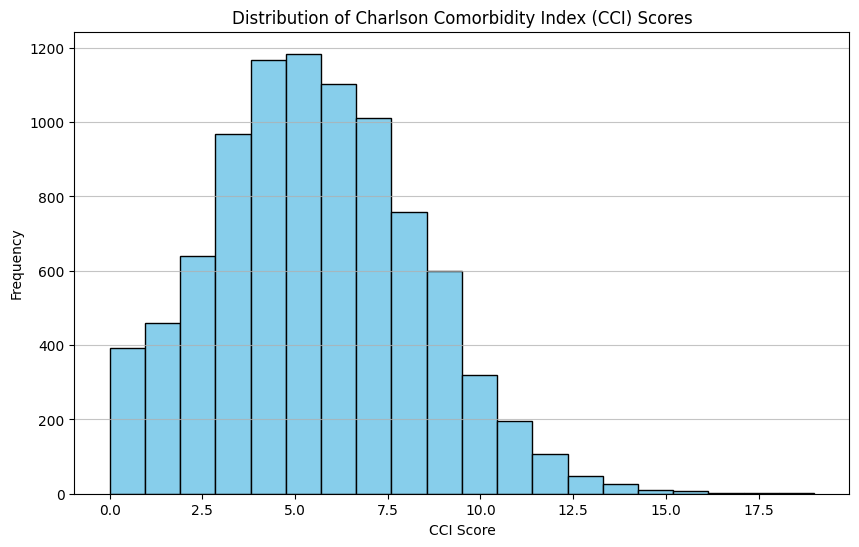

In [27]:
# Plot the distribution of the 'cci' column
plt.figure(figsize=(10, 6))
plt.hist(sl2['cci'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Charlson Comorbidity Index (CCI) Scores')
plt.xlabel('CCI Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [29]:
cci_mean = sl2.cci.mean()
cci_median = sl2.cci.median()
cci_std = sl2.cci.std()
cci_min = sl2.cci.min()
cci_max = sl2.cci.max()

print('Charlson Comorbidity Index')
print(f'cci_mean: {cci_mean}')
print(f'cci_median: {cci_median}')
print(f'cci_std: {cci_std}')
print(f'cci_range: {cci_min} - {cci_max}')

Charlson Comorbidity Index
cci_mean: 5.374763967566367
cci_median: 5.0
cci_std: 2.9182664910450136
cci_range: 0 - 19
